In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
import os
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, optimizer=fast_compile, floatX=float32'

import keras
import joblib
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM
from keras.models import Sequential, Model
from keras.layers import concatenate, merge, GRU, RepeatVector, Lambda, Reshape, Permute, Bidirectional, Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, Convolution1D, MaxPooling1D, GlobalMaxPooling1D
import keras.backend as K
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomUniform

import numpy as np
import pdb

import gensim, sklearn
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec, KeyedVectors

import codecs

import operator
from string import punctuation
from collections import defaultdict
import sys
import csv
import string
from nltk import tokenize as tokenize_nltk

In [2]:
ask_path = '/raid/data/niloofarsafi/project/ask.fm_data/'
wiki_path = '/raid/data/niloofarsafi/project/wiki/'
kaggle_path = '/raid/data/niloofarsafi/project/kaggle_new/'

seed_number = 1234
np.random.seed(seed_number)

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (2, 3, 4)
num_filters = 100
dropout_prob = (0.0, 0.5)

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 25
max_words = 20000

# Word2Vec parameters 
min_word_count = 1
context = 10

### Evaluation code

In [3]:
def final_labels2(y_actual, y_pred):
    y_tru=[]
    for lbl in y_actual:
        if lbl == 1:
            y_tru += ["negative"]
        else:
            y_tru += ["positive"] 
    y_te=[]
    for lbl in y_pred:
        if lbl[0]>lbl[1]:
            y_te += ["positive"]
        else:
            y_te += ["negative"]
    return y_tru, y_te

In [4]:
def report(le, y_test, y_pred):
        print("Classifation Report")

        
        target_names = le.classes_
        class_indices = {cls: idx for idx, cls in enumerate(le.classes_)}
        print(class_indices)

        print(metrics.classification_report(y_test, y_pred, target_names=target_names,
                                            labels=["" + str(class_indices[cls]) for cls in target_names]))
        
        
        print("============================================================")
        print("Confusion matrix")
        print("============================================================")
        print(target_names)
        print(confusion_matrix(y_test, y_pred,
            labels=[class_indices[cls] for cls in target_names]))

        precision_micro, recall_micro, fscore_micro, _ = \
        precision_recall_fscore_support(y_test, y_pred,
                                                                                           average='micro',
                                                                                           pos_label=None)
        precisions_macro, recalls_macro, fscore_macro, _ =\
        precision_recall_fscore_support(y_test, y_pred,
                                                                                           average='macro',
                                                                                           pos_label=None)
        precisions_weighted, recalls_weighted, fscore_weighted, _ =\
        precision_recall_fscore_support(y_test, y_pred,
                                                                                                    average='weighted',
                                                                                                    pos_label=None)
        
        measures = "p: %.4f r: %.4f f1: %.4f"
        print("Micro:  " + measures % (precision_micro, recall_micro, fscore_micro))
        print("Macro:  " + measures % (precisions_macro, recalls_macro, fscore_macro))
        print("Weight: " + measures % (precisions_weighted, recalls_weighted, fscore_weighted))

        print('Test Accuracy: %.4f' % accuracy_score(y_test, y_pred))
        print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
        print('Misclassified samples: %d' % (y_test != y_pred).sum())
        print("============================================================")

### Loading Data

In [5]:
train = []
train_lower = []
train_label = []

dev = []
dev_label = []

test = []
test_lower = []
test_label = []

text = ''

with open(ask_path+'train.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
        
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
        train.append(q)
        train_lower.append(q.lower())
        train_label.append(lab1)
        train.append(a)
        train_lower.append(a.lower())
        train_label.append(lab2)
        
#         text1 = ' '.join(train)

with open(ask_path+'dev.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
            
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
        train.append(q)
        train_lower.append(q.lower())
        train_label.append(lab1)
        train.append(a)
        train_lower.append(a.lower())
        train_label.append(lab2)
#         dev.append(q)
#         dev_label.append(lab1)
#         dev.append(a)
#         dev_label.append(lab2)
        
        text2 = ' '.join(train)
        
with open(ask_path+'test.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
            
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
            
        test.append(q)
        test_label.append(lab1)
        test_lower.append(q.lower())
        test.append(a)
        test_label.append(lab2)
        test_lower.append(a.lower())
        
        text3 = ' '.join(test)

print('length of train: ', len(train))
# print('length of dev: ', len(dev))
print('length of test: ', len(test))
print('length of train_lower: ', len(train_lower))
# print('length of dev: ', len(dev))
print('length of test_lower: ', len(test_lower))

text = text2 + ' ' + text3

length of train:  7834
length of test:  3360
length of train_lower:  7834
length of test_lower:  3360


In [6]:
# labels = train_label + dev_label
labels = train_label
print(np.unique(labels))

c_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(labels), labels)
print(c_weight)

class_weights = {}
for num, w in enumerate(c_weight):
    class_weights[num] = w
print(class_weights)

train_y = keras.utils.to_categorical(train_label, 2)
# dev_y = keras.utils.to_categorical(dev_label, 2)
test_y = keras.utils.to_categorical(test_label, 2)

[0 1]
[ 0.61126717  2.74684432]
{0: 0.61126716604244691, 1: 2.7468443197755961}


### Character Representation

In [44]:
chars = sorted(list(set(text.lower())))
vocab_size = len(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print("Total number of chars:", len(text))
print("Vocabulary size:", vocab_size)

def char_mapping(char_indices, documents):
    X = []
    for doc in documents:
        doc_vec = []
        for word in doc.lower():
            for token in word:
                doc_vec.append(char_indices[token])
        X.append(doc_vec)
    return X
                

char_train = char_mapping(char_indices, train)
# char_dev = char_mapping(char_indices, dev)
char_test = char_mapping(char_indices, test)

maxlen = 150

char_x_train = pad_sequences(char_train, maxlen=maxlen)
# char_x_dev = pad_sequences(char_dev, maxlen=maxlen)
char_x_test  = pad_sequences(char_test, maxlen=maxlen)

Total number of chars: 712849
Vocabulary size: 299


### Word Representation

In [8]:
all_data = train + test
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_data)

train_sequence = tokenizer.texts_to_sequences(train)
# dev_sequence = tokenizer.texts_to_sequences(dev)
test_sequence = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index

vocabulary_inv = dict((v, k) for k, v in word_index.items())
vocabulary_inv[0] = "<PAD/>"
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

# label = train_label + dev_label
train_data = pad_sequences(train_sequence, maxlen=sequence_length, padding="post", truncating="post")
# dev_data = pad_sequences(dev_sequence, maxlen=sequence_length, padding="post", truncating="post")
test_data = pad_sequences(test_sequence, maxlen=sequence_length, padding="post", truncating="post")
# labels = np.array

Vocabulary Size: 10997


### Embedding Initialization

In [9]:
googleNews = False

if googleNews:
    print("Using GoogleNews word2vec representations!")
    embedding_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    for key, word in vocabulary_inv.items():
        if word in embedding_model:
            embedding_weights[key] = embedding_model[word]
        else:
            oov_counter += 1
            embedding_weights[key] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
            
    print('Null word embeddings: %d' % oov_counter)

    
else:
    print("Using our own pre-trained model")
    pretrained = 'AskWordModel.model'
    embedding_model = KeyedVectors.load(pretrained)
    oov_counter = 0
    embedding_weights = {}
#     print(embedding_model.vector_size)
    for key, word in vocabulary_inv.items():
        if word in embedding_model:
            embedding_weights[key] = embedding_model[word]
        else:
            oov_counter += 1
            embedding_weights[key] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
            
    print('Null word embeddings: %d' % oov_counter)

Using our own pre-trained model
Null word embeddings: 3410


### Hand-crafted Features

In [35]:
feature_path = '/raid/data/niloofarsafi/project/extracted_features'

feat_list = ['qa', 'liwc']

def get_features(suffix):
    feature_list = []
    for feature in feat_list:
#         print ("Feature : %s" % feature)
        path = os.path.join(feature_path, feature + suffix + '.pkl')
        loaded_feature = joblib.load(path)

        if not isinstance(loaded_feature, np.ndarray):
            loaded_feature = loaded_feature.toarray()

        feature_list.append(loaded_feature)
#     print(len(feature_list))
    return feature_list

def get_feature(suffix, feature):
    print ("Feature : %s" % feature)
    path = os.path.join(feature_path, feature + suffix + '.pkl')
    loaded_feature = joblib.load(path)

    if not isinstance(loaded_feature, np.ndarray):
        loaded_feature = loaded_feature.toarray()
    
    return loaded_feature

def combination(feature_list):
    return np.concatenate((feature_list), axis=1)
    

qa_train = get_feature("_train", 'qa')
qa_test = get_feature("_test", 'qa')

print("Shape of qa_train: ", qa_train.shape)
print("Shape of qa_test: ", qa_test.shape)

qa_shape = qa_train.shape[1]

liwc_train = get_feature("_train", 'liwc')
liwc_test = get_feature("_test", 'liwc')

print("Shape of liwc_train: ", liwc_train.shape)
print("Shape of liwc_test: ", liwc_test.shape)

liwc_shape = liwc_train.shape[1]

all_feature_train = combination(get_features("_train"))
all_feature_test = combination(get_features("_test"))

print("Shape of all_feature_train: ", all_feature_train.shape)
print("Shape of all_feature_test: ", all_feature_test.shape)

all_shape = all_feature_train.shape[1]

Feature : qa
Feature : qa
Shape of qa_train:  (7834, 460)
Shape of qa_test:  (3360, 460)
Feature : liwc
Feature : liwc
Shape of liwc_train:  (7834, 64)
Shape of liwc_test:  (3360, 64)
Shape of all_feature_train:  (7834, 524)
Shape of all_feature_test:  (3360, 524)


### Neural Network

In [152]:
def get_input_layer(shape, name):
    return Input(shape=shape, dtype='int32', name='{}_input'.format(name))

def pretrained_embedding_layer(embeddings, input_layer, input_len, name):
    embed_layer = Embedding(embeddings.shape[0], 
                           embeddings.shape[1], 
                           input_length=input_len, 
                           weights=[embeddings],
                           trainable=False,
                           name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.25, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer
    
    
def rand_uniform_embedding_layer(input_layer, input_dim, output_dim, input_len, name):
    uniform = RandomUniform(seed=seed_number, 
                            minval=-np.sqrt(3/output_dim),  # Suggested by
                            maxval= np.sqrt(3/output_dim))  # He et al (2015) 
    embed_layer = Embedding(input_dim=input_dim, 
                            output_dim=output_dim,
                            input_length=input_len, 
                            embeddings_initializer=uniform,
                            trainable=False,
                            name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.25, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer

#64
def get_char_cnn(embedded, name, filters=100, kernel_size=4, dense_units=32, convs=3):
    conv_net = embedded
    for _ in range(convs):
        conv_net = Convolution1D(filters=filters, kernel_size=kernel_size, activation='relu')(conv_net)
    conv_net = GlobalAveragePooling1D()(conv_net)
    conv_net = Dense(dense_units, activation='relu', name='{}_dense'.format(name))(conv_net)
    return conv_net

def get_char_cnn2(embedded, name, filters=100, kernel_size=[4], dense_units=32):
    z = embedded
    conv_blocks = []
    for ks in kernel_size:
        conv_net = Convolution1D(filters=filters, kernel_size=ks, activation='relu')(z)
        conv_net = GlobalAveragePooling1D()(conv_net)
        conv_blocks.append(conv_net)
    z2 = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    return z2

### Character Based CNN

In [153]:
char_dim = 40
maxlen = 150
char_input = get_input_layer((maxlen,), 'char_ask')
char_embed = rand_uniform_embedding_layer(char_input, 
                                                len(char_indices), 
                                                char_dim, 
                                                maxlen, 
                                                'char_ask')
char_encoded = char_embed

char_encoded = get_char_cnn(char_encoded, 'char_encoded', kernel_size=4, convs=1)

char_encoder = Model(inputs=[char_input], outputs=[char_encoded])
char_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
char_ask_input (InputLayer)  (None, 150)               0         
_________________________________________________________________
char_ask_embed (Embedding)   (None, 150, 40)           11960     
_________________________________________________________________
char_ask_embed_dropout (Drop (None, 150, 40)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 147, 100)          16100     
_________________________________________________________________
global_average_pooling1d_10  (None, 100)               0         
_________________________________________________________________
char_encoded_dense (Dense)   (None, 32)                3232      
Total params: 31,292
Trainable params: 19,332
Non-trainable params: 11,960
_________________________________________________________________


### Word Based CNN

In [154]:
word_input = get_input_layer((sequence_length,), 'word_ask')

word_embed = rand_uniform_embedding_layer(word_input, 
                                                len(vocabulary_inv), 
                                                embedding_dim, 
                                                sequence_length, 
                                                'word_ask')

# input_shape = (sequence_length,)
# model_input = Input(shape=input_shape)

# output_dim = 40

# uniform = RandomUniform(seed=seed_number, 
#                             minval=-np.sqrt(3/output_dim),  # Suggested by
#                             maxval= np.sqrt(3/output_dim))  # He et al (2015) 

# # Embedding layer
# embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, 
#                             embeddings_initializer=uniform,
#                             name="embedding")
# z = embedding_layer(model_input)
# z = Dropout(0.25)(z)
num_filters = 100
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(word_embed)
    conv = GlobalMaxPooling1D()(conv)
#     conv = Dense(32, activation='relu')(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

word_encoded = Dense(128, activation='relu')(z)

word_encoder = Model(inputs=[word_input], outputs=[word_encoded])
word_encoder.summary()

# Dropout 
# z = Dropout(dropout_prob[1])(z)

# Output layer
# model_output = Dense(2, activation="softmax")(z)

# # Model compilation
# model_rand = Model(model_input, model_output)
# model_rand.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model_rand.summary(85)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ask_input (InputLayer)     (None, 25)           0                                            
__________________________________________________________________________________________________
word_ask_embed (Embedding)      (None, 25, 300)      3299100     word_ask_input[0][0]             
__________________________________________________________________________________________________
word_ask_embed_dropout (Dropout (None, 25, 300)      0           word_ask_embed[0][0]             
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 24, 100)      60100       word_ask_embed_dropout[0][0]     
__________________________________________________________________________________________________
conv1d_45 

### BLSTM

In [155]:
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
ask_input = get_input_layer((sequence_length,), 'rnn_ask')
ask_embed = pretrained_embedding_layer(weights, 
                                           ask_input, 
                                           sequence_length, 
                                           'rnn_ask')

ask_encoded = Bidirectional(LSTM(100, 
                                  return_sequences=False, 
                                  dropout=0.2, 
                                  recurrent_dropout=0.2), 
                             name='word_encoded_blstm')(ask_embed)

ask_encoded = Dropout(0.5, name='word_encoded_blstm_dropout')(ask_encoded)

# ask_output = Dense(2, activation="softmax")(word_encoded)

ask_encoder = Model(ask_input, ask_encoded)
# rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

ask_encoder.summary(80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
rnn_ask_input (InputLayer)          (None, 25)                      0           
________________________________________________________________________________
rnn_ask_embed (Embedding)           (None, 25, 300)                 3299100     
________________________________________________________________________________
rnn_ask_embed_dropout (Dropout)     (None, 25, 300)                 0           
________________________________________________________________________________
word_encoded_blstm (Bidirectional)  (None, 200)                     320800      
________________________________________________________________________________
word_encoded_blstm_dropout (Dropout (None, 200)                     0           
Total params: 3,619,900
Trainable params: 320,800
Non-trainable params: 3,299,100
___________________________

### Feed Forward

In [156]:
feature_input = get_input_layer((all_shape,), 'hand_crafted')

feature_encoded = Dense(500, kernel_initializer='normal', activation="relu")(feature_input)
feature_encoded = Dropout(0.5)(feature_encoded)

feature_encoded = Dense(200, kernel_initializer='normal', activation="relu")(feature_encoded)
feature_encoded = Dropout(0.5)(feature_encoded)

# feature_encoded = Dense(100, kernel_initializer='normal', activation="relu")(feature_encoded)
# feature_encoded = Dropout(0.5)(feature_encoded)

# feature_encoded = Dense(50, kernel_initializer='normal', activation="relu")(feature_encoded)
# feature_encoded = Dropout(0.5)(feature_encoded)

feature_encoder = Model(feature_input, feature_encoded)
feature_encoder.summary(80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
hand_crafted_input (InputLayer)     (None, 524)                     0           
________________________________________________________________________________
dense_48 (Dense)                    (None, 500)                     262500      
________________________________________________________________________________
dropout_34 (Dropout)                (None, 500)                     0           
________________________________________________________________________________
dense_49 (Dense)                    (None, 200)                     100200      
________________________________________________________________________________
dropout_35 (Dropout)                (None, 200)                     0           
Total params: 362,700
Trainable params: 362,700
Non-trainable params: 0
_____________________________________

### Concatenation and Final Model

In [157]:
network = concatenate([char_encoded, word_encoded, ask_encoded, feature_encoded], name='concatenation')
# network = Dense(400, activation='relu', name='common_dense') (network)
network = Dense(200, activation='relu', name='common_dense2') (network)

output = Dense(2, activation='softmax', name='output')(network)

char_inputs = [char_input]
word_inputs = [word_input]
ask_inputs = [ask_input]
feature_inputs = [feature_input]

model = Model(inputs=[char_input, word_input, ask_input, feature_input], 
              outputs=[output], 
              name='final_model')
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ask_input (InputLayer)     (None, 25)           0                                            
__________________________________________________________________________________________________
char_ask_input (InputLayer)     (None, 150)          0                                            
__________________________________________________________________________________________________
word_ask_embed (Embedding)      (None, 25, 300)      3299100     word_ask_input[0][0]             
__________________________________________________________________________________________________
char_ask_embed (Embedding)      (None, 150, 40)      11960       char_ask_input[0][0]             
__________________________________________________________________________________________________
word_ask_e

In [158]:
num_epochs = 50

history = {}

weight_file = '/raid/data/niloofarsafi/project/comb1_balanced_weights.h5'

checkpoint = ModelCheckpoint(weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit([char_x_train, train_data, train_data, all_feature_train], 
                    train_y, 
                    batch_size=500, 
                    epochs=num_epochs,
                    class_weight=class_weights, 
                    validation_split=0.2, 
                    verbose=1, 
                    callbacks=[early, checkpoint])

ERROR (theano.gof.opt): Optimization failure due to: local_gpu_softmax_with_bias
ERROR (theano.gof.opt): node: SoftmaxWithBias(dot.0, HostFromGpu.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/gof/opt.py", line 1982, in process_node
    replacements = lopt.transform(node)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/opt.py", line 1389, in local_gpu_softmax_with_bias
    gpu_sm = GpuSoftmaxWithBias()(as_cuda_ndarray_variable(x),
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/basic_ops.py", line 46, in as_cuda_ndarray_variable
    return gpu_from_host(tensor_x)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/gof/op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cud

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.6575 - acc: 0.6146 - val_loss: 0.5752 - val_acc: 0.6369
Epoch 2/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.5689 - acc: 0.7110 - val_loss: 0.5126 - val_acc: 0.7530
Epoch 3/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.5181 - acc: 0.7547 - val_loss: 0.4993 - val_acc: 0.7345
Epoch 4/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.4725 - acc: 0.7772 - val_loss: 0.4958 - val_acc: 0.7339
Epoch 5/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.4235 - acc: 0.8077 - val_loss: 0.4954 - val_acc: 0.7320
Epoch 6/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.3624 - acc: 0.8307 - val_loss: 0.5095 - val_acc: 0.7601
Epoch 7/50
6267/6267 [==============================] - 22s 4ms/step - loss: 0.3045 - acc: 0.8656 - val_loss: 0.5189 - val_acc: 0.7594
Epoch 8

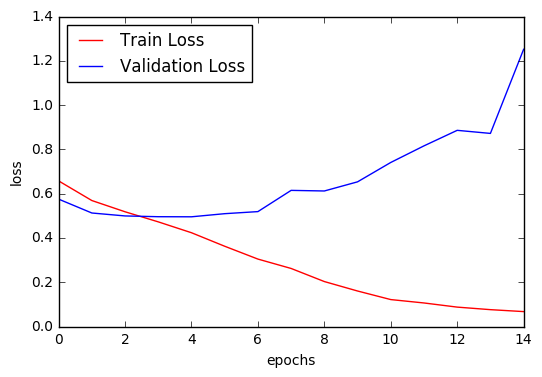

In [159]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(range(len(train_loss)), train_loss, color="red", label="Train Loss")
plt.plot(range(len(train_loss)), val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

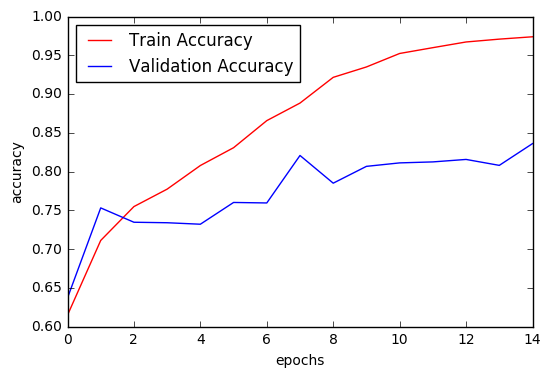

In [160]:
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.plot(range(len(train_acc)), train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(train_acc)), val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [161]:
model.load_weights(weight_file)
predicted = model.predict([char_x_test, test_data, test_data, all_feature_test])
label_encoder = LabelEncoder()
# y_tru, static_y_te = final_labels(test_label, static_predicted, 0.49)
y_tru, y_te = final_labels2(test_label, predicted)
# print(len(y_tru))
# print(len(y_te))
y_te = label_encoder.fit_transform(y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, y_te)

ERROR (theano.gof.opt): Optimization failure due to: local_gpu_softmax_with_bias
ERROR (theano.gof.opt): node: SoftmaxWithBias(dot.0, HostFromGpu.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/gof/opt.py", line 1982, in process_node
    replacements = lopt.transform(node)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/opt.py", line 1389, in local_gpu_softmax_with_bias
    gpu_sm = GpuSoftmaxWithBias()(as_cuda_ndarray_variable(x),
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/basic_ops.py", line 46, in as_cuda_ndarray_variable
    return gpu_from_host(tensor_x)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/gof/op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/theano/sandbox/cud

Classifation Report
{'positive': 1, 'negative': 0}
             precision    recall  f1-score   support

   negative       0.40      0.84      0.55       597
   positive       0.96      0.73      0.83      2763

avg / total       0.86      0.75      0.78      3360

Confusion matrix
['negative' 'positive']
[[ 504   93]
 [ 741 2022]]
Micro:  p: 0.7518 r: 0.7518 f1: 0.7518
Macro:  p: 0.6804 r: 0.7880 f1: 0.6881
Weight: p: 0.8581 r: 0.7518 f1: 0.7790
Test Accuracy: 0.7518
ROC AUC: 0.788
Misclassified samples: 834


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [168]:
for i in range(len(y_te)):
    if y_te[i] != y_tru[i]:
        print(test[i])
        print()
        print(label_encoder.inverse_transform(y_tru[i]))
        print(label_encoder.inverse_transform(y_te[i]))
        print()

what the fuck is up with your spelling  but i hangout with  karl  alfonso  jose  fernando  edith  and brenda

positive
negative

Haha if only  But no that would fuck up things   i doubt management is that dumb

positive
negative

Ur ass in those pants today damn

positive
negative

I liked ur shorts today  They showed off ur ASS  

positive
negative

fuck me lol

positive
negative

roseana is talking shit bout u

positive
negative

There is a fucking difference between loving someone and simply having a crush on them do these girs know how to tell the difference      I love you I love you plz kolo 5ra and grow up   

positive
negative

r u a bitch

positive
negative

who is that guy that s asking all of those questions about katie     say or name  bitch       elizabeth  

positive
negative

Don t you just hate it when you take a poop and you start wiping  and then wiping  and then wiping  and then wiping  but the poop streak doesn t go away from your butt hole until you either cont